# Example: Buck converter

Example created by Gabriel Bueno Leandro

<div style="text-align: justify"> A buck converter is a type of DC/DC converter that decreases the voltage (while increasing the current) from its input (power supply) to its output (load). It is similar to a boost converter (elevator) and is a type of switched-mode power supply (SMPS) that typically contains at least two semiconductors (a diode and a transistor, although modern buck converters replace the diode with a second transistor used for synchronous rectification) and at least one energy storage element, a capacitor, inductor or both combined. </div>

## Reference 

**The following text was taken from the link https://www.researchgate.net/publication/216771768_Multiobjective_parameter_estimation_for_nonlinear_systems_Affine_information_and_least-squares_formulation**. 



In [49]:
# Importing the libraries and methods needed to run the notebook.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.multiobjective_parameter_estimation import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

# Dynamic Behavior

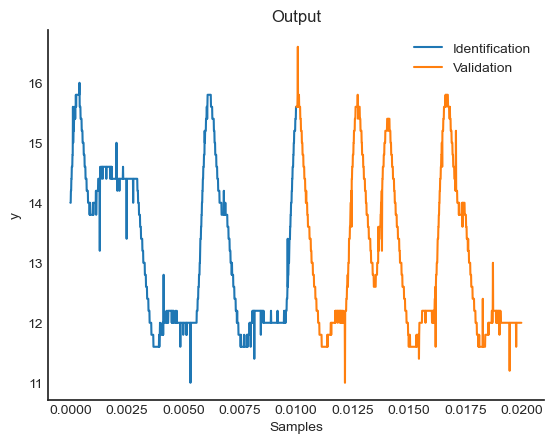

In [50]:
# Reading Buck's input and output data
data_train = pd.read_csv(r'examples/datasets/buck.txt' , sep=" ", header=None).to_numpy()
data_valid = pd.read_csv("examples/datasets/buck_val.txt" , sep =" ", header=None).to_numpy()

# Separating the identification data
data_samples_train = data_train[:, 2]
data_out_train = data_train[:, 6]
data_int_train = data_train[:, 4]

# Separating the validation data
data_samples_valid = data_valid[:, 2]
data_out_valid = data_valid[:, 6]
data_int_valid = data_valid[:, 4]

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title('Output')
plt.plot(data_samples_train, data_out_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_out_valid , label='Validation', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('y')
plt.legend()
plt.show()


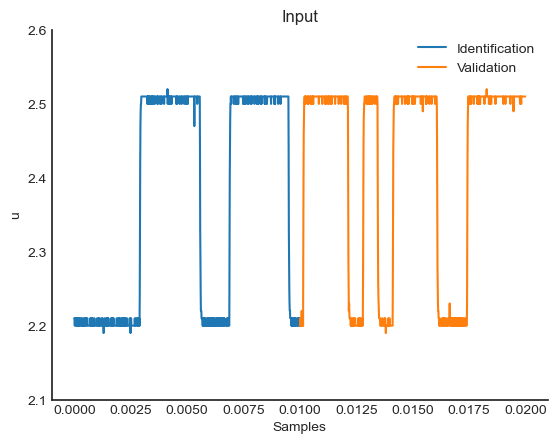

In [51]:
# Plotting the measured input(identification and validation data)
plt.figure(2)
plt.title('Input')
plt.plot(data_samples_train, data_int_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_int_valid, label='Validation', linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel('u')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Buck Converter Static Function

The duty cycle is defined by $D=\frac{T_{on}}{T}$ and its complement is $D'=\frac{T_{off}}{T}$ , where T is the operation cycle. The load voltage $V_o$ relates to the source voltage $V_d$ as $V_o = D\cdot V_d = (1 − D’)\cdot V_d$. This converter satisfies $D' = \frac{\bar{u}-1}{3}$ and therefore the static function of this system is known from theory to be:
$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

assuming $V_d = 24\:V $, the expression can be rewritten as follows:

$$
V_o = (4 - \bar{u})\cdot 8
$$

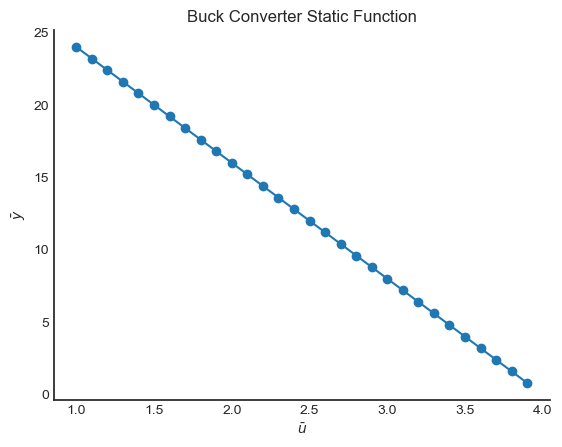

In [52]:
# Static data
Vd = 24
Yo = np.zeros(30)
Uo = np.zeros(30)
for t in range(10, 40):
    Uo[t-10] = (t)/10
    Yo[t-10] = (4-Uo[t-10])*Vd/3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title('Buck Converter Static Function')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{y}$')
plt.plot(Uo, Yo, linewidth=1.5, linestyle='-', marker='o')
plt.show()

# Buck converter static gain

The gain of the Buck converter can be described as the derivative of the static function, which is described by:

$$
V_o = (4 - \bar{u})\cdot 8
$$

soon $gain=V_o'=-8$


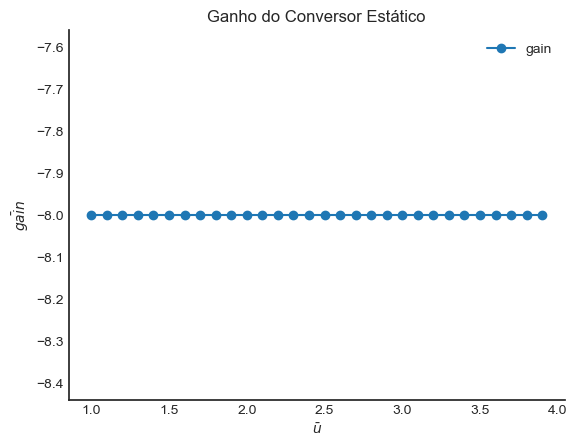

In [53]:
# Definindo o ganho
gain = -8*np.ones(len(Uo)).reshape(-1, 1)
plt.figure(3)
plt.title('Ganho do Conversor Estático')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{gain}$')
plt.plot(Uo, gain, linewidth=1.5, label='gain', linestyle='-', marker='o')
plt.legend()
plt.show()

Information about static function and static gain, together with the usual input/output data, have been used as sources of affine information to estimate the parameters of the model. The composite cost function is:

$$
\gamma(\hat\theta) = w_1\cdot J_{LS}(\hat{\theta})+w_2\cdot J_{SF}(\hat{\theta})+w_3\cdot J_{SG}(\hat{\theta})
$$


In [54]:
# Informing test and validation data
x_train = data_int_train.reshape(-1, 1)
y_train = data_out_train.reshape(-1, 1)
x_valid = data_int_valid.reshape(-1, 1)
y_valid = data_out_valid.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

c:\Users\55359\OneDrive\Área de Trabalho\Clone_git\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


The next step will be to determine the weights of the objectives of interest:

In [55]:
# Matrix with the weights.
W = np.array([[0.98, 0.7, 0.5, 0.35, 0.25, 0.01, 0.15, 0.01],
              [0.01, 0.1, 0.3, 0.15, 0.25, 0.98, 0.35, 0.01],
              [0.01, 0.2, 0.2, 0.50, 0.50, 0.01, 0.50, 0.98]])


with the parameters all in hand, we can already calculate the parameters in a multiobjective way:

In [56]:
# Calling the class referring to the calculation of the parameters via the multiobjective technique
mult = IM(n_inputs=model.n_inputs,
       non_degree=model.non_degree,
       model_type=model.model_type,
       final_model = model.final_model)



now the method will be called to calculate the matrix of the performance of the objectives (J), weights (w), the Euclidean norm (E), the thetas referring to each weight (Theta), matrix H multiplied by R and the matrix Q multiplied by R.


In [57]:
# Method to calculate the parameters
J, w, E, Theta, HR, QR, position = mult.affine_information_least_squares(y_train=y_train[2:],
                                                                         gain=gain,y_static=Yo,
                                                                         x_static=Uo, psi=model.psi)
result = {'w1': w[0,:],
          'w2': w[2,:],
          'w3': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          'J_sf': J[2,:],
          '||J||:': E}
pd.DataFrame(result)


,w1,w2,w3,J_ls,J_sg,J_sf,||J||:
0,0.990080,0.003078,0.006842,0.951073,8.672442e-03,0.242326,0.981498
1,0.990080,0.001031,0.008889,0.951338,2.475265e-03,0.210740,0.974403
2,0.762007,0.231152,0.006842,0.951595,2.316952e-06,0.184811,0.969375
3,0.762007,0.229104,0.008889,0.951649,6.444982e-07,0.179571,0.968443
4,0.762007,0.226443,0.011550,0.951733,1.429145e-05,0.173058,0.967339
...,...,...,...,...,...,...,...
348,0.006842,0.645763,0.347396,0.999496,6.512415e-07,0.000016,0.999496
349,0.006842,0.541785,0.451374,0.999723,9.377762e-07,0.000011,0.999723
350,0.006842,0.406686,0.586472,0.999916,1.684581e-06,0.000008,0.999916
351,0.006842,0.231152,0.762007,1.000000,5.258082e-06,0.000006,1.000000


now we can choose a theta value referring to the weights:

In [58]:
# Writing the results
model.theta = Theta[position, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),3.9338E-01,9.999E-01
1,y(k-2),6.2121E-01,2.042E-05
2,x1(k-1)y(k-1),-2.2144E-02,1.108E-06
3,1,3.9002E-01,4.688E-06
4,y(k-1)^2,2.8417E-01,3.922E-07
5,x1(k-1),2.1600E-02,8.389E-07
6,y(k-2)y(k-1),-5.5164E-01,5.690E-07
7,y(k-2)^2,2.6775E-01,3.827E-06


dynamic data in graphical form:

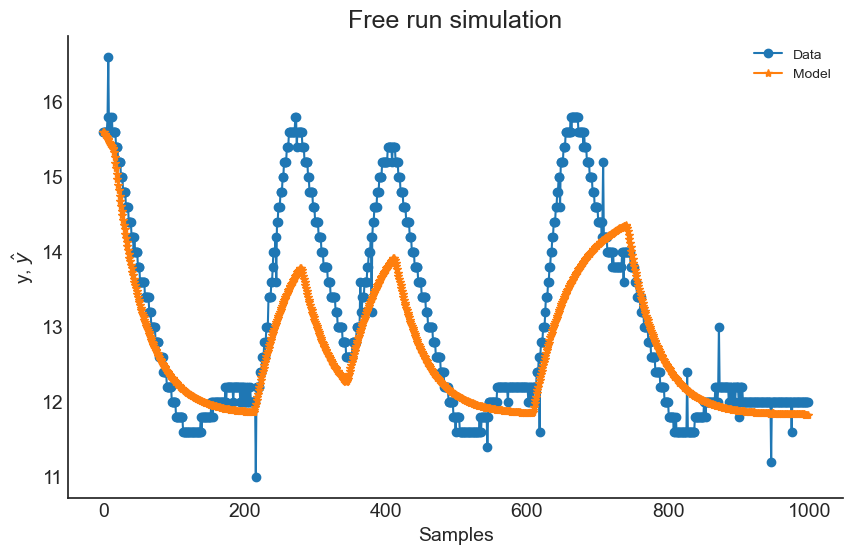

In [59]:
plot_results(y=y_valid, yhat=yhat, n=1000)

the static gain graphically:

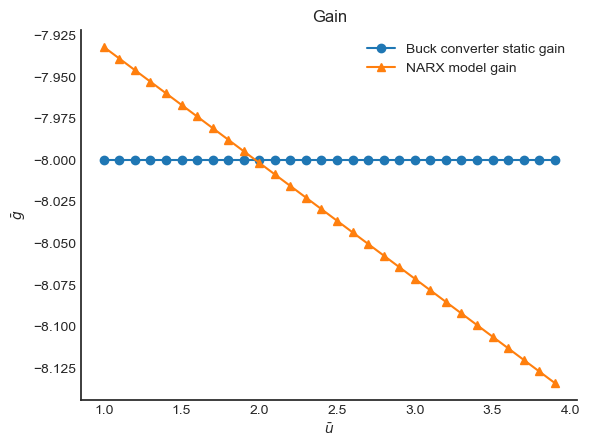

In [60]:
plt.figure(4)
plt.title('Gain')
plt.plot(Uo, gain, linewidth=1.5, linestyle='-', marker='o', label='Buck converter static gain')
plt.plot(Uo, HR.dot(model.theta),  linestyle='-', marker='^', linewidth=1.5, label='NARX model gain')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{g}$')
plt.legend()
plt.show()

the static function graphically:

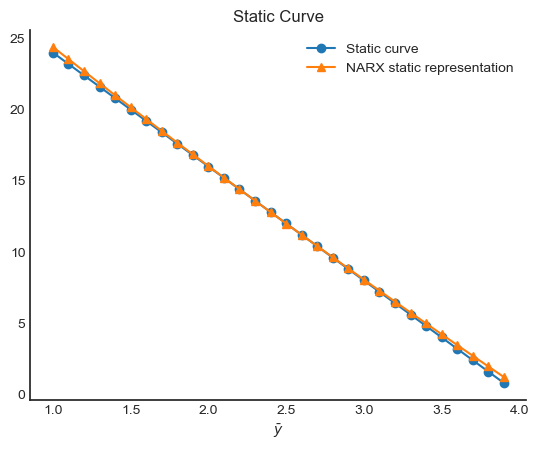

In [61]:
plt.figure(5)
plt.title('Static Curve')
plt.plot(Uo, Yo, linewidth=1.5, label='Static curve',  linestyle='-', marker='o')
plt.plot(Uo, QR.dot(model.theta), linewidth=1.5, label='NARX ​​static representation', linestyle='-', marker='^')
plt.xlabel('$\\bar{u}$')
plt.xlabel('$\\bar{y}$')
plt.legend()
plt.show()

pareto-optimal curve:

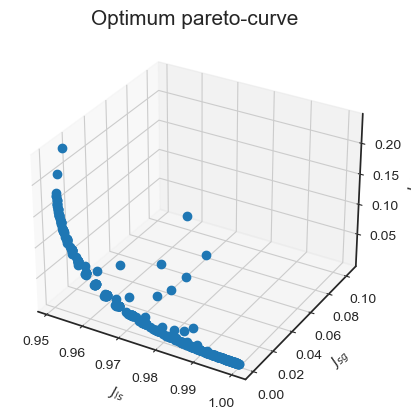

In [62]:
plt.figure(6)
ax = plt.axes(projection='3d')
ax.plot3D( J[0,:],  J[1,:],  J[2,:], 'o', linewidth=0.1)
ax.set_title('Optimum pareto-curve', fontsize=15)
ax.set_xlabel('$J_{ls}$', fontsize=10)
ax.set_ylabel('$J_{sg}$', fontsize=10)
ax.set_zlabel('$J_{sf}$', fontsize=10)
plt.show()

The found NARX polynomial model was:

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 u(k-1) y(k-1) + \theta_4 + \theta_5 y(k-1)^2 + \theta_6 u(k-1) + \theta_7 y(k-2)y(k-1) + \theta_8 y(k-2)^2
$$

the goal is to estimate the vector $\hat{\theta}$, peparting from:

$$
\theta = [w_1\Psi^T\Psi + w_2(HR)^T(HR) + w_3(QR)(QR)^T]^{-1} [w_1\Psi^T y + w_2(HR)^T\overline{g}+w_3(QR)^T\overline{y}]
$$

the $\Psi$ matrix is provided by SysIdentPy. However, it is still necessary to find the Q, H and R matrices. To do this, $q_i^T$ is first estimated:

$$
q_i^T = 
\begin{bmatrix}
1 & \overline{y_i} & \overline{u_1} & \overline{y_i}^2 & \cdots & \overline{y_i}^l &  F_{yu} & \overline{u_i}^2 & \cdots & \overline{u_i}^l
\end{bmatrix}
$$

where $F_{yu}$ stands for all non-linear monomials inthe model that involve $y(k)$ and $u(k)$, $l$ is the largestnon-linearity in the model and need not be the samefor input and output terms. For a model with a degree of nonlinearity equal to 2, matrix-wise the following is obtained:


$$
q_i^T = 
\begin{bmatrix}
1 & \overline{y_i} & \overline{u_i} & \overline{y_i}^2 & \overline{u_i}\:\overline{y_i} & \overline{u_i}^2 
\end{bmatrix}
$$

here, it is possible to encode the $q_i^T$ matrix so that it is in compliance with SysIdentPy. To do this, 0 is considered as a constant, $y_i$ equal to 1 and $u_i$ equal to 2. The number of columns indicates the degree of nonlinearity of the system and the number of rows reflects the number of terms in the mode:


$$
q_i = 
\begin{bmatrix}
0 & 0\\
1 & 0\\
2 & 0\\
1 & 1\\
2 & 1\\
2 & 2\\
\end{bmatrix}
= 
\begin{bmatrix}
1 \\
\overline{y_i}\\
\overline{u_i}\\
\overline{y_i}^2\\
\overline{u_i}\:\overline{y_i}\\
\overline{u_i}^2\\
\end{bmatrix}
$$

the result can be easily obtained using the ‘regressor_space’ method of SysIdentPy:

In [63]:
from sysidentpy.narmax_base import RegressorDictionary # Importing the class.
object_qit = RegressorDictionary(xlag=[1], ylag=[1]) # The lag of the input and output equal to 1 ensures that there will be no repetition of terms in qit.
R_example = object_qit.regressor_space(n_inputs=1)//1000 
print(f'R = {R_example}')

R = [[0 0]
 [1 0]
 [2 0]
 [1 1]
 [2 1]
 [2 2]]


such that:

$$
\overline{y_i} = q_i^T R\theta
$$

and:

$$
\overline{g_i} = H R\theta
$$

the $R$ matrix is the linear mapping of the static regressors represented by $q_i^T$. In addition, the $H$ matrix contains affine information regarding $\overline{g_i}$, which is equal to $\overline{g_i} = \frac{d\overline{y}}{d\overline{u}}{\big |}_{(\overline{u_i}\:\overline{y_i})}$. From now on, we will begin to apply the estimation of parameters in a multi-objective manner. This will be done with the NARX polynomial model of the BUCK converter in mind. In this context, $q_i^T$ will cease to be generic and will assume a specific format for the problem at hand. For this task, the $R_qit$ method will be used, whose objective is to return the $q_i^T$ related to the model and the matrix of the linear mapping $R$:

In [64]:
R, qit = mult.R_qit()
print('R matrix:')
print(R)
print('qit matrix:')
print(qit)

R matrix:
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
qit matrix:
[[0 0]
 [1 0]
 [2 0]
 [1 1]
 [2 1]]


immediately:

$$
q_i = 
\begin{bmatrix}
0 & 0\\
1 & 0\\
2 & 0\\
1 & 1\\
2 & 1\\ 
\end{bmatrix}
=
\begin{bmatrix}
1\\
\overline{y}\\
\overline{u}\\
\overline{y^2}\\
\overline{u}\:\overline{y}\\ 
\end{bmatrix}
$$

upon returning to the model, it is possible to observe that the method produces outputs consistent with what is expected:

$$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 u(k-1) y(k-1) + \theta_4 + \theta_5 y(k-1)^2 + \theta_6 u(k-1) + \theta_7 y(k-2)y(k-1) + \theta_8 y(k-2)^2
$$

and:

$$ 
R = 
\begin{bmatrix}
term/\theta & \theta_1 & \theta_2 & \theta_3 & \theta_4 & \theta_5 & \theta_6 & \theta_7 & \theta_8\\
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
\overline{y} & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
\overline{u} & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
\overline{y^2} & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1\\
\overline{y}\:\overline{u} & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}
$$